In [125]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin

In [137]:
def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100):

    key = 'decoded_pdfs.crosssession.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1, 2])
        pdf.columns = pdf.columns.astype(float)

        pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

        pdf = pdf.loc[:, np.log(5):np.log(112)]

        E = (pdf*pdf.columns.values[np.newaxis, :] / pdf.sum(1).values[:, np.newaxis]).sum(1)

        E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels)],
        names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).to_frame('E')

        E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

        return E
    else:
        print(pdf)
        return pd.DataFrame(np.zeros((0, 0)))

In [138]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True)]
sessions = [2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr']
n_voxels = [0, 100]

pred = []
for (sub, session, pcac, den, smooth, mask, nv) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels):
    pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv))

  0%|          | 0/140 [00:00<?, ?it/s]

In [139]:
df = get_all_behavior(drop_no_responses=False)
pred = pd.concat(pred)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:66: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21935/1625089706.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


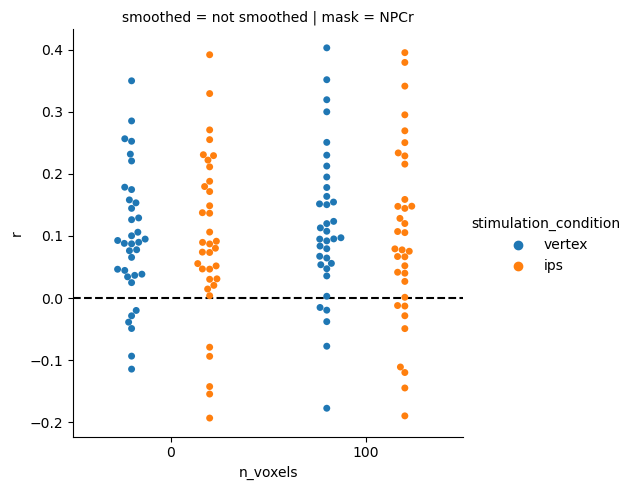

In [140]:
import seaborn as sns
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
plt.axhline(0, c='k', ls='--')

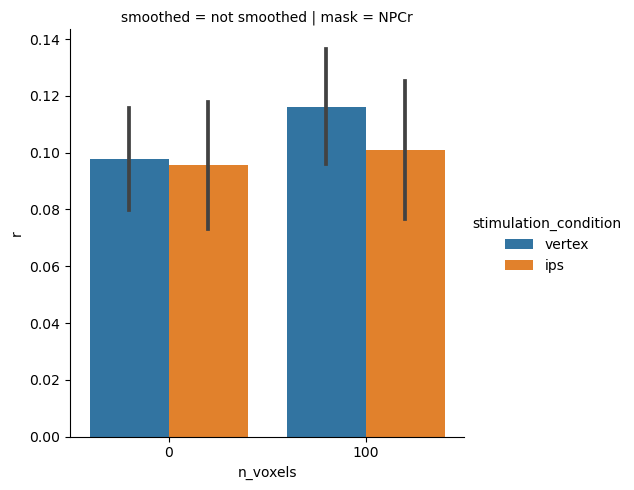

In [141]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se')

In [142]:
pred['error'] = pred['E'] - pred['log(n1)']

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21935/2386813843.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().reset_index(), x='n_voxels', col='risky_first', hue='stimulation_condition', y='error', kind='point', errorbar='se')


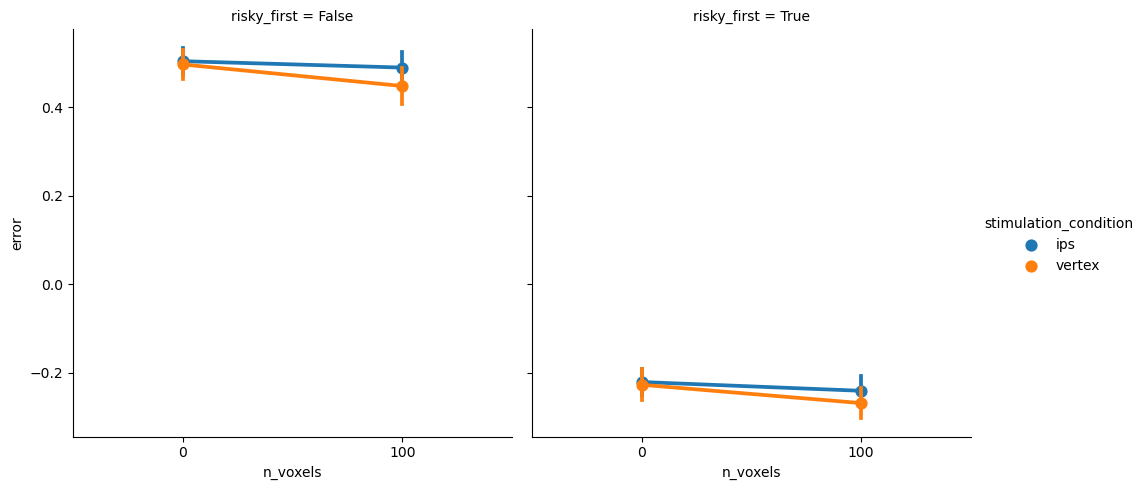

In [143]:
sns.catplot(data=pred.groupby(['subject', 'n_voxels', 'stimulation_condition', 'risky_first']).mean().reset_index(), x='n_voxels', col='risky_first', hue='stimulation_condition', y='error', kind='point', errorbar='se')

In [133]:
pred.groupby(['subject', 'session', 'n_voxels']).size().groupby(['n_voxels', 'session']).size()

n_voxels  session
0         2          35
          3          35
100       2          35
          3          35
dtype: int64

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_21935/1664714461.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()


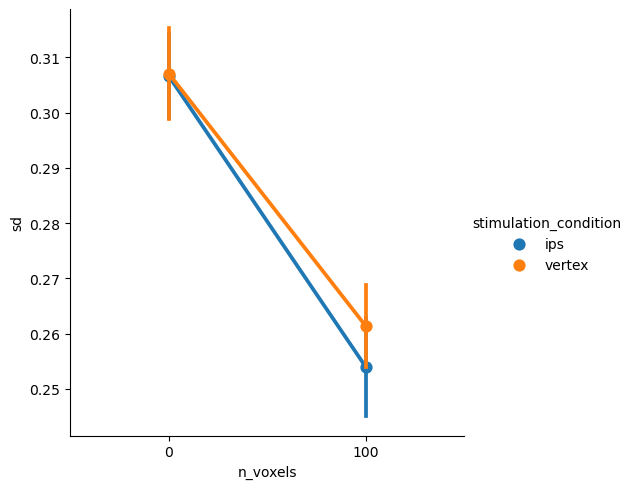

In [149]:
tmp = pred.groupby(['subject', 'stimulation_condition', 'n_voxels']).mean()

sns.catplot(x='n_voxels', y='sd', hue='stimulation_condition', data=tmp.reset_index(), kind='point', errorbar='se')